In [13]:
import cv2
from keras import Model
from keras.layers import Conv2D, Flatten, Dense , Input , MaxPool2D , RandomZoom , RandomFlip , RandomRotation
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.preprocessing import LabelBinarizer , LabelEncoder
import matplotlib.pyplot as plt
from keras.layers import Rescaling,Dropout
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.datasets import fetch_lfw_people


print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [70]:
class database():
    def __init__(self , path_face_classifier , path_IMAGE_DIR):
        self.face_classifier = cv2.CascadeClassifier(path_face_classifier)
        self.IMAGE_DIR = path_IMAGE_DIR

    def my_data(self , height , width ):

        x_train = []
        y_labels = []
        for root, directories, files in os.walk(self.IMAGE_DIR):

            for file in files:
                if file.endswith("png") or file.endswith("jpg") :
                    path = os.path.join(root, file)

                    label = os.path.basename(os.path.dirname(path))

                    image = cv2.imread(path)
                    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)


                    faces = self.face_classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)



                    for x, y, w, h in faces:

                        rect_gray = gray[y:y + h, x:x + w]
                        rect_gray = cv2.resize(rect_gray, (height, width), interpolation=cv2.INTER_CUBIC)


                        x_train.append(rect_gray)
                        y_labels.append(label)


        return x_train , y_labels



In [71]:
face_classifier = "C:\\Users\\bpk_e.EMRE\\Desktop\\PROJECTS\\chatBot\\ImageProcessing\\haarcascade_frontalface_default.xml"
IMAGE_DIR = "C:\\Users\\bpk_e.EMRE\\Desktop\\PROJECTS\\chatBotLastPhase\\ImageProcessing\\Data\\Images"

x_images, y_labels = database(path_face_classifier=face_classifier , path_IMAGE_DIR = IMAGE_DIR).my_data( height=100,width=100)

len(x_images)

X = np.array(x_images)
Y = np.array(y_labels)

In [62]:

a = fetch_lfw_people(funneled=True , min_faces_per_person = 50 , download_if_missing = True )
x_images = a.images
y_labels = a.target

idx = np.argsort(y_labels)

X = np.array(x_images[idx])
Y = np.array(y_labels)[idx]

total length  680
n 7


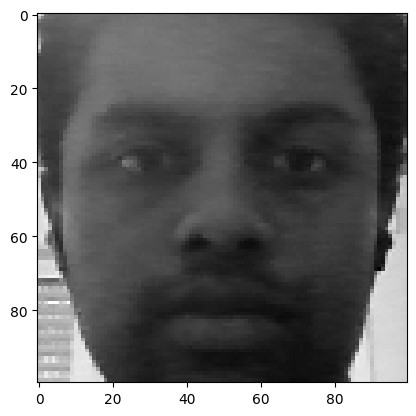

In [171]:
X_filtered = []
Y_filtered = []


max_number_of_images_per_person_in_dataset = 1000
number_of_people = 12


for i in np.unique(Y):
    first_index = np.where(Y == i)[0][0]
    max_ = len(np.where(Y==i)[0])
    # print(f"label {i} , number of images {max_}" )
    for j in range( min( max_ , max_number_of_images_per_person_in_dataset) ):
        if(Y[j+first_index] == i):
            x = X[j+first_index]
            y = Y[j+first_index]

            X_filtered.append(x)
            Y_filtered.append(y)

    if len(np.unique(Y_filtered)) >= number_of_people:
        break

print("total length ", len(X_filtered))

n = len(np.unique(Y_filtered))
print("n" , n)

plt.imshow(X_filtered[8] , cmap='gray')

In [173]:
encoder = LabelBinarizer()

Y_encoded = encoder.fit_transform(Y_filtered)

X_train, X_test, Y_train, Y_test = train_test_split(X_filtered,Y_encoded,test_size = 0.2 , stratify= Y_encoded, shuffle=True )
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,test_size = 0.3 ,stratify=Y_train, shuffle=True )

print(len(X_train) , len(X_val) , len(X_test))
print(len(Y_train), len(Y_val), len(Y_test))

380 164 136
380 164 136


In [174]:
img_size = X_train[0].shape


def create_model():
    input_image = Input(shape=(img_size[0],img_size[1], 1) , name='input')

    rescale = Rescaling(1/255)(input_image)

    c1 = Conv2D(32, (4,4), activation='relu')(rescale)
    m1 = MaxPool2D((2,2))(c1)

    c2 = Conv2D(64, (3,3), activation='relu')(m1)
    m2 = MaxPool2D((2,2))(c2)
    f1 = Flatten()(m2)

    d1 = Dense(128  , activation='sigmoid')(f1)

    output = Dense(n , activation='softmax')(d1)

    model = Model(inputs=[input_image], outputs=[output])
    model.compile(optimizer='adam', loss= keras.losses.CategoricalCrossentropy(), metrics=keras.metrics.CategoricalAccuracy())

    return model


In [175]:
epoch = 500
batch_size = 64
patience = 250
callback = keras.callbacks.EarlyStopping(monitor='val_loss' , patience=patience, restore_best_weights=True  )

# history = model.fit(np.array(X_train), np.array(Y_train_), epochs=epoch, batch_size =batch_size,validation_data=( np.array(X_val_),np.array(Y_val_)) ,callbacks=[callback] , use_multiprocessing = True)
# #
# score, acc = model.evaluate(np.array(X_test), np.array(Y_test) )
# print(score,acc)

In [176]:
from sklearn.model_selection import KFold

skf = KFold(n_splits=5, shuffle=True )
acc_per_fold = []
loss_per_fold = []
models = []
# K-fold Cross Validation model evaluation

fold_no = 1
for k, (train_index, val_index) in enumerate(skf.split(X_filtered, Y_filtered)):

    X_new_train = []
    for i in train_index:
        X_new_train.append(X_filtered[i])

    X_new_val = []
    for j in val_index:
        X_new_val.append(X_filtered[j])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    model = create_model()

    history = model.fit(np.array(X_new_train), Y_encoded[train_index], epochs=epoch, batch_size =batch_size, validation_data=(np.array(X_val), np.array(Y_val)), callbacks=[callback], use_multiprocessing = True, verbose=0)

    models.append(model)

    scores = model.evaluate(np.array(X_new_val), Y_encoded[val_index], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

  # Increase fold number
    fold_no = fold_no + 1


max_index = acc_per_fold.index(max(acc_per_fold))
final_model = models[max_index]

print(np.array(acc_per_fold).mean())

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 4.6935656428104267e-05; categorical_accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 4.7124656703090295e-05; categorical_accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 5.7284749345853925e-05; categorical_accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.02611105516552925; categorical_accuracy of 99.26470518112183%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 7.382930198218673e-05; categorical_accuracy of 100.0%
99.85294103622437


EXPERIMENTS ON

In [157]:
def eval_(y , y_hat):
    counter = 0
    for a , b in zip(y,y_hat):
        if a == b :
            counter += 1

    return counter / len(y)

In [169]:

from sklearn.model_selection import StratifiedKFold , KFold
skf = KFold(n_splits=5, shuffle=True )


le = LabelEncoder()
Y_int_labels = le.fit_transform(Y_filtered)

acc_per_fold_lbph = []
# K-fold Cross Validation model evaluation
fold_no = 1
for k, (train_index, val_index) in enumerate(skf.split(X_filtered, Y_int_labels)):

    model_lbhf = cv2.face.FisherFaceRecognizer.create()

    X_new_train = []
    Y_new_train = []

    for i in train_index:
        X_new_train.append(X_filtered[i])
        Y_new_train.append(Y_int_labels[i])

    X_new_val = []
    Y_new_val = []
    for j in val_index:
        X_new_val.append(X_filtered[j])
        Y_new_val.append(Y_int_labels[j])
    model_lbhf.train(np.array(X_new_train) ,  np.array(Y_new_train))

    y_predictions = []

    for test_instance in X_new_val:
        test_pred = model_lbhf.predict(np.array(test_instance))
        y_predictions.append(test_pred[0])

    acc = eval_(Y_new_val , y_predictions)
    acc_per_fold_lbph.append(acc)

print(np.array(acc_per_fold_lbph).mean() * 100)

88.57142857142858


In [178]:
# Directory to export new model
final_model.save("C:\\Users\\bpk_e.EMRE\\Desktop\\PROJECTS\\chatBotLastPhase\\ImageProcessing\\Model\\final_model")

INFO:tensorflow:Assets written to: C:\Users\bpk_e.EMRE\Desktop\PROJECTS\chatBotLastPhase\ImageProcessing\Model\final_model\assets


In [179]:
# labels = np.flip(np.unique(Y_train,axis=0),1)

labels = np.unique(Y_filtered)
indices = range(0,len(labels))
dict_ = {indices[i]: labels[i] for i in range(len(labels))}

print(dict_)
import json
with open('C:\\Users\\bpk_e.EMRE\\Desktop\\PROJECTS\\chatBotLastPhase\\ImageProcessing\\Model\\labels.json', 'w') as f:
    json.dump(dict_, f)

{0: 'Akhilesh', 1: 'Anna', 2: 'Emmanuel', 3: 'Emre_Karabulut', 4: 'Gabrijel', 5: 'Joshua', 6: 'Lea'}


In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['categorical_accuracy']
val_accuracy = history_dict['val_categorical_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, label='Training accuracy')
ax[0].plot(epochs, val_accuracy, label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, label='Training loss')
ax[1].plot(epochs, val_loss_values, label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()



In [ ]:
plt.savefig("LFW - min 50")

In [ ]:
from PIL import ImageFont
import visualkeras

font = ImageFont.truetype("arial.ttf", 12)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True, font=font ,type_ignore=[RandomZoom, RandomFlip, RandomRotation , Flatten ,Dropout])  # font is optional!

In [ ]:
# def data_aug(x_images, y_labels , copy_number_per_image):
#     data = []
#     labels = []
#     for i in range(len(x_images)):
#         img = x_images[i]
#         label = y_labels[i]
#
#         for j in range(copy_number_per_image):
#
#             img_ = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1, 2))
#             img_ = tf.image.stateless_random_contrast(img_, lower=0.6, upper=1, seed=(1,3))
#             img_ = tf.image.stateless_random_flip_left_right(img_, seed=(np.random.randint(100),np.random.randint(100)))
#             img_ = tf.image.stateless_random_jpeg_quality(img_, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
#             img_ = tf.image.stateless_random_saturation(img_, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
#
#             data.append(img_)
#             labels.append(label)
#     print(len(data), len(labels))
#     return data , labels